In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from ibm_watson import PersonalityInsightsV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import json
from matplotlib import pyplot
import matplotlib
import matplotlib.pyplot as plt
import kaggle
from os.path import expanduser
from glob import glob
import ipywidgets as widgets
%matplotlib inline
# df = pd.read_csv('/Users/simonlipson/git_repos/machine_learning/friends_scripts.csv')

In [55]:
#Crawl all friends scripts for first 9 seasons
pages = []
for i in range(101,923):
    page = requests.get('https://fangj.github.io/friends/season/0{}.html'.format(i))
    pages.append(page)

In [63]:
#Parse all scraped htmls into beautiful soups
soups = []
for page in pages:
    if page.status_code == 200:
        soup = BeautifulSoup(page.content, 'html.parser')
        soups.append(soup)

In [64]:
len(soups)

207

In [ ]:
soups[0].prettify

In [67]:
len(soups[0].find_all('b'))

299

In [71]:
#Scrape all the lines from the scripts and put them into data frames
frames = []
for soup in soups:
    lines = []
    for i in range(2,len(soup.find_all('p'))):
        lines.append(soup.find_all('p')[i].get_text())
    df = pd.DataFrame({'line':lines})
    frames.append(df)

In [72]:
len(frames)

207

In [75]:
df = pd.concat(frames, axis= 0)
df.shape

(56908, 1)

In [76]:
df.head()

,line
0,Monica: There's nothing to tell! He's just som...
1,"Joey: C'mon, you're going out with the guy! Th..."
2,"Chandler: All right Joey, be\nnice. So does h..."
3,"Phoebe: Wait, does he eat chalk?"
4,"(They all stare, bemused.)"


In [77]:
#Split the data frame so the each character is in the first column
df = df.line.str.split(":", expand = True)
df.shape

(56908, 290)

In [79]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,280,281,282,283,284,285,286,287,288,289
count,56908,52126,339,69,61,57,57,55,54,53,...,1,1,1,1,1,1,1,1,1,1
unique,4070,44281,322,66,60,56,56,54,53,52,...,1,1,1,1,1,1,1,1,1,1
top,Rachel,,00.,Hey!\nJoey,You really liked it?\nChandler,"Oh yeah! I mean at first I hated it, but why ...","""fat, single and ready to mingle"", I was upli...",Oh really!\nChandler,"Oh yeah, I had no idea the amazing journey yo...",No!\nChandler,...,No.\n(Rachel goes look for Joey. She sees him...,"(to Rachel) Hey Rach, have you seen Charlie a...",I'm smarter than him!\nClosing credits[Scene,"The theater. Monica, Phoebe and Chandler are ...","Hey, thank you so much for these tickets, Cha...","Oh well, this was a really important experien...","Oh, you're so wonderful.\nBitter woman",Why don't you like me! Chapter one,my first period.\nChandler,"Can't believe you guys bought that, enjoy you..."
freq,7505,1159,6,3,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


In [96]:
#Replace None values with empty strings for later concatination
df.fillna(value=pd.np.nan, inplace=True)
df.fillna("", inplace = True)
df

,0,1,2,3,4,5,6,7,8,9,...,280,281,282,283,284,285,286,287,288,289
0,Monica,There's nothing to tell! He's just some guy\n...,,,,,,,,,...,,,,,,,,,,
1,Joey,"C'mon, you're going out with the guy! There's...",,,,,,,,,...,,,,,,,,,,
2,Chandler,"All right Joey, be\nnice. So does he have a ...",,,,,,,,,...,,,,,,,,,,
3,Phoebe,"Wait, does he eat chalk?",,,,,,,,,...,,,,,,,,,,
4,"(They all stare, bemused.)",,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,Jeanette,(to Zack) Here are the boards for Friday's pi...,,,,,,,,,...,,,,,,,,,,
334,Zack,"Oh, thank you.",,,,,,,,,...,,,,,,,,,,
335,(Jeanette walks out),,,,,,,,,,...,,,,,,,,,,
336,Chandler,You wouldn't know if Jeanette's planning on k...,,,,,,,,,...,,,,,,,,,,


In [101]:
#Concatinate all columns into one except for the character column
df['all_text'] = df.loc[:, df.columns != 0].apply(''.join, axis=1)

In [104]:
#Clean df of junk
df = df[[0,'all_text']]

In [105]:
df.columns = ['friend', 'line']

In [106]:
df.describe()

,friend,line
count,56908,56908
unique,4070,44351
top,Rachel,
freq,7505,5877


In [4]:
#Remove irrelevant rows
friends = ['Chandler', 'Ross', 'Rachel', 'Monica', 'Joey', 'Phoebe']
df = df.loc[df['friend'].isin(friends)]
df

,Unnamed: 0,friend,line
0,0,Monica,There's nothing to tell! He's just some guy\n...
1,1,Joey,"C'mon, you're going out with the guy! There's..."
2,2,Chandler,"All right Joey, be\nnice. So does he have a ..."
3,3,Phoebe,"Wait, does he eat chalk?"
4,5,Phoebe,"Just, 'cause, I don't want her to go through\..."
...,...,...,...
40548,325,Chandler,"Hey, Zack!"
40549,327,Chandler,"Look, I just wanted to apologize for last nig..."
40550,329,Chandler,Really?
40551,331,Chandler,"My wife and I have some boundary issues, you ..."


In [5]:
df.groupby('friend').count()

,Unnamed: 0,line
friend,,
Chandler,6754,6517
Joey,6536,6329
Monica,6681,6535
Phoebe,5963,5797
Rachel,7505,7303
Ross,7114,6874


In [9]:
#Create dataframe for each character
df_friends = []
for friend in friends:
    globals()['df_' + friend] = df.loc[df['friend']==friend][['friend', 'line']]
    df_friends.append(globals()['df_' + friend])

In [25]:
#Get all dialogue per character into text block
for friend in friends:
    globals()[friend] = ' '.join(globals()['df_'+friend]['line'].dropna().tolist())

In [213]:
#IBM api key 
# a9-W7C3dAxBKH5XirZMEgavr3NL2VhpNHlfH5Fn3PCsB

In [26]:
# url = 'https://gateway.watsonplatform.net/personality-insights/api'
#Instantiate IBM Watson Personality Insights service
authenticator = IAMAuthenticator('Be785piW-5_PT6GVRQwXFX5tHCD-zTtL0cfESb9j3sV6')
service = PersonalityInsightsV3(authenticator = authenticator, version='2017-10-13')
service.set_service_url('https://api.eu-gb.personality-insights.watson.cloud.ibm.com/instances/636a8bd3-1de0-4bb5-bd45-748b1c2afa4d')
service

In [27]:
#Create personality profiles for each character based on IBM Watson 
for friend in friends:
    globals()[friend + '_profile'] = service.profile(
                                                    globals()[friend],
                                                    'application/json',
                                                    consumption_preferences=True,
                                                    raw_scores=True
                                                    ).get_result()
    print(len(globals()[friend + '_profile']))

7
7
7
7
7
7


In [28]:
print(json.dumps(Chandler_profile, indent=2))

{
  "word_count": 48715,
  "processed_language": "en",
  "personality": [
    {
      "trait_id": "big5_openness",
      "name": "Openness",
      "category": "personality",
      "percentile": 0.7210579897333197,
      "raw_score": 0.7673604671182116,
      "significant": true,
      "children": [
        {
          "trait_id": "facet_adventurousness",
          "name": "Adventurousness",
          "category": "personality",
          "percentile": 0.6548715977807952,
          "raw_score": 0.5189909546300243,
          "significant": true
        },
        {
          "trait_id": "facet_artistic_interests",
          "name": "Artistic interests",
          "category": "personality",
          "percentile": 0.5827127702347561,
          "raw_score": 0.6758968449583559,
          "significant": true
        },
        {
          "trait_id": "facet_emotionality",
          "name": "Emotionality",
          "category": "personality",
          "percentile": 0.6084138585784621,
       

In [475]:
def friends_create_personality_plot(level):
    labels = [big5['name'] for big5 in Chandler_profile[level]]
    chandler_p = [big5['percentile'] for big5 in Chandler_profile[level]]
    monica_p = [big5['percentile'] for big5 in Monica_profile[level]]
    joey_p = [big5['percentile'] for big5 in Joey_profile[level]]
    phoebe_p = [big5['percentile'] for big5 in Phoebe_profile[level]]
    ross_p = [big5['percentile'] for big5 in Ross_profile[level]]
    rachel_p = [big5['percentile'] for big5 in Rachel_profile[level]]

    barWidth = 0.10  # the width of the bars

    # Set position of bar on X axis
    r1 = np.arange(len(chandler_p))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]

    # Make the plot
    plt.bar(r1, chandler_p, color='#cc6600', width=barWidth, edgecolor='white', label='chandler')
    plt.bar(r2, monica_p, color='#cccc00', width=barWidth, edgecolor='white', label='monica')
    plt.bar(r3, joey_p, color='#66cc00', width=barWidth, edgecolor='white', label='joey')
    plt.bar(r4, phoebe_p, color='#0099cc', width=barWidth, edgecolor='white', label='phoebe')
    plt.bar(r5, ross_p, color='#9900cc', width=barWidth, edgecolor='white', label='ross')
    plt.bar(r6, rachel_p, color='#cc0033', width=barWidth, edgecolor='white', label='rachel')



    # Add xticks on the middle of the group bars
    plt.xlabel(level, fontweight = 'bold')
    plt.xticks([r + barWidth for r in range(len(chandler_p))], labels)
    plt.rcParams["figure.figsize"] = (30,8)
    matplotlib.rcParams.update({'font.size': 18})
    plt.ylabel('Percentile', fontweight = 'bold')

    # Create legend & Show graphic
    plt.legend()
    plt.show()


In [29]:
#import sex and city data downloaded from Kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files('snapcrack/every-sex-and-the-city-script', path=expanduser('~/TMP/SATC_all_lines'), unzip=True)

for name in glob(expanduser('~/TMP/SATC_all_lines/*')):
    if '.csv' in name:
        stc_data = pd.read_csv(name)

In [30]:
stc_data['Speaker'].value_counts()

Carrie           13941
Miranda           4780
Samantha          4067
Charlotte         3667
Big               1233
                 ...  
Cops                 1
Repairman            1
Man on street        1
Prada Clerk          1
voice mail           1
Name: Speaker, Length: 795, dtype: int64

In [31]:
#Remove all irrelevant lines
stc_data = stc_data.loc[stc_data['Speaker']
                        .isin(['Carrie', 'Miranda', 'Samantha', 'Charlotte'])][['Speaker', 'Line']]

In [32]:
stc_data.describe()

,Speaker,Line
count,26455,26455
unique,4,24439
top,Carrie,No.
freq,13941,54


In [33]:
stc_chars = ['Carrie', 'Samantha', 'Miranda', 'Charlotte']

In [34]:
#Get all lines per character in text block
stc_dialogue_list = []
for char in stc_chars:
    globals()[char + '_dialogue'] = stc_data.loc[stc_data['Speaker']==char]['Line']
    stc_dialogue_list.append(globals()[char + '_dialogue'])
    
for i, dialogue in enumerate(stc_dialogue_list):
    globals()[stc_chars[i] + '_text'] = ' '.join(dialogue.tolist())

In [35]:
#Create personality profiles for each character based on IBM Watson 
for char in stc_chars:
    globals()[char + '_profile'] = service.profile(
                                                    globals()[char + '_text'],
                                                    'application/json',
                                                    consumption_preferences=True,
                                                    raw_scores=True
                                                    ).get_result()
    print(len(globals()[char + '_profile']))

7
7
7
7


In [ ]:
def stc_create_personality_plot(level):
    labels = [big5['name'] for big5 in Carrie_profile[level]]
    carrie_p = [big5['percentile'] for big5 in Carrie_profile[level]]
    samantha_p = [big5['percentile'] for big5 in Samantha_profile[level]]
    charlotte_p = [big5['percentile'] for big5 in Charlotte_profile[level]]
    miranda_p = [big5['percentile'] for big5 in Miranda_profile[level]]
    

    barWidth = 0.15  # the width of the bars

    # Set position of bar on X axis
    r1 = np.arange(len(carrie_p))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Make the plot
    plt.bar(r1, carrie_p, color='#cc6600', width=barWidth, edgecolor='white', label='carrie')
    plt.bar(r2, samantha_p, color='#cccc00', width=barWidth, edgecolor='white', label='samantha')
    plt.bar(r3, charlotte_p, color='#66cc00', width=barWidth, edgecolor='white', label='charlotte')
    plt.bar(r4, miranda_p, color='#0099cc', width=barWidth, edgecolor='white', label='miranda')



    # Add xticks on the middle of the group bars
    plt.xlabel(level, fontweight = 'bold')
    plt.xticks([r + barWidth for r in range(len(carrie_p))], labels)
    plt.rcParams["figure.figsize"] = (30,8)
    matplotlib.rcParams.update({'font.size': 18})
    plt.ylabel('Percentile', fontweight = 'bold')

    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [36]:
#Import all seinfeld screenplays from Kaggle 
kaggle.api.authenticate()

kaggle.api.dataset_download_files('thec03u5/seinfeld-chronicles', path=expanduser('~/TMP/seinfeld'), unzip=True)

for name in glob(expanduser('~/TMP/seinfeld/*')):
    if '.csv' in name:
        seinfeld_data = pd.read_csv(name)


In [37]:
seinfeld_data['Character'].value_counts()

JERRY                               14786
GEORGE                               9708
ELAINE                               7983
KRAMER                               6664
NEWMAN                                640
                                    ...  
ELAINE (on the witness stand)           1
[GEORGE                                 1
JERRY (still trying to remember)        1
GEORGE/JERRY/ELAINE/WENDY               1
NEWMANEWMAN                             1
Name: Character, Length: 1639, dtype: int64

In [38]:
seinfeld_data = seinfeld_data.loc[seinfeld_data['Character']
                                                            .isin(['JERRY', 'GEORGE', 'ELAINE', 'KRAMER'])][['Character', 'Dialogue']]

In [39]:
seinfeld_data.describe()

,Character,Dialogue
count,39141,39141
unique,4,35202
top,JERRY,Yeah.
freq,14786,339


In [40]:
seinfeld_chars = ['JERRY', 'GEORGE', 'ELAINE', 'KRAMER']

In [41]:
dialogue_list = []
for char in seinfeld_chars:
    globals()[char + '_dialogue'] = seinfeld_data.loc[seinfeld_data['Character']==char]['Dialogue']
    dialogue_list.append(globals()[char + '_dialogue'])

In [42]:
for i, dialogue in enumerate(dialogue_list):
    globals()[seinfeld_chars[i] + '_text'] = ' '.join(dialogue.tolist())

In [67]:
for char in seinfeld_chars:
    globals()[char + '_profile'] = service.profile(
                                                    globals()[char + '_text'],
                                                    'application/json',
                                                    consumption_preferences=True,
                                                    raw_scores=True
                                                    ).get_result()
    print(len(globals()[char + '_profile']))

7
7
7
7


In [440]:
print(json.dumps(JERRY_profile, indent=2))

{
  "word_count": 48734,
  "processed_language": "en",
  "personality": [
    {
      "trait_id": "big5_openness",
      "name": "Openness",
      "category": "personality",
      "percentile": 0.7316628572879367,
      "raw_score": 0.7683777367232919,
      "significant": true,
      "children": [
        {
          "trait_id": "facet_adventurousness",
          "name": "Adventurousness",
          "category": "personality",
          "percentile": 0.7947322828296204,
          "raw_score": 0.5340868268924364,
          "significant": true
        },
        {
          "trait_id": "facet_artistic_interests",
          "name": "Artistic interests",
          "category": "personality",
          "percentile": 0.5477375594831432,
          "raw_score": 0.6713968827672987,
          "significant": true
        },
        {
          "trait_id": "facet_emotionality",
          "name": "Emotionality",
          "category": "personality",
          "percentile": 0.6161483212289552,
       

In [478]:
def sf_create_personality_plot(level):
    labels = [big5['name'] for big5 in JERRY_profile[level]]
    jerry_p = [big5['percentile'] for big5 in JERRY_profile[level]]
    george_p = [big5['percentile'] for big5 in GEORGE_profile[level]]
    elaine_p = [big5['percentile'] for big5 in ELAINE_profile[level]]
    kramer_p = [big5['percentile'] for big5 in KRAMER_profile[level]]
    

    barWidth = 0.15  # the width of the bars

    # Set position of bar on X axis
    r1 = np.arange(len(jerry_p))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Make the plot
    plt.bar(r1, jerry_p, color='#cc6600', width=barWidth, edgecolor='white', label='jerry')
    plt.bar(r2, george_p, color='#cccc00', width=barWidth, edgecolor='white', label='george')
    plt.bar(r3, elaine_p, color='#66cc00', width=barWidth, edgecolor='white', label='elaine')
    plt.bar(r4, kramer_p, color='#0099cc', width=barWidth, edgecolor='white', label='kramer')



    # Add xticks on the middle of the group bars
    plt.xlabel(level, fontweight = 'bold')
    plt.xticks([r + barWidth for r in range(len(jerry_p))], labels)
    plt.rcParams["figure.figsize"] = (30,8)
    matplotlib.rcParams.update({'font.size': 18})
    plt.ylabel('Percentile', fontweight = 'bold')

    # Create legend & Show graphic
    plt.legend()
    plt.show()


In [45]:
kaggle.api.authenticate()

kaggle.api.dataset_download_files('andradaolteanu/rickmorty-scripts', path=expanduser('~/TMP/r_n_morty'), unzip=True)

for name in glob(expanduser('~/TMP/r_n_morty/*')):
    if '.csv' in name:
        r_n_m_data = pd.read_csv(name)

In [46]:
r_n_m_data['name'].value_counts()

Rick                      420
Morty                     347
Beth                      148
Jerry                     132
Summer                     97
Pickle Rick                77
Supernova                  44
Cop Morty                  34
All Ricks                  32
Mr. Goldenfold             28
President                  27
Testicle Monster A         26
Cop Rick                   26
Principal Vagina           25
Snuffles                   22
Cornvelious Daniel         22
Dr. Wong                   21
Drunk Rick                 21
Agency Director            20
Alan                       19
Candidate Morty            18
Vance                      17
Scary Terry                17
Jessica                    16
Million Ants               15
All Mortys                 15
Ice-T                      13
Morty 2                    13
All Summers                13
Riq IV                     13
Campaign Manager Morty     12
Alien Doctor               12
Lizard Morty               11
Slick     

In [47]:
rick_and_morty_lines = r_n_m_data.loc[r_n_m_data['name'].isin(['Rick', 'Morty'])][['name', 'line']]

In [48]:
rick_text = ' '.join(rick_and_morty_lines.loc[rick_and_morty_lines['name']=='Rick']['line'].tolist())
morty_text = ' '.join(rick_and_morty_lines.loc[rick_and_morty_lines['name']=='Morty']['line'].tolist())

In [49]:
for char in ['rick', 'morty']:
    globals()[char + '_profile'] = service.profile(
                                                    globals()[char + '_text'],
                                                    'application/json',
                                                    consumption_preferences=True,
                                                    raw_scores=True
                                                    ).get_result()
    print(len(globals()[char + '_profile']))

7
7


In [137]:
def rnm_create_personality_plot(level):
    labels = [big5['name'] for big5 in rick_profile[level]]
    rick_p = [big5['percentile'] for big5 in rick_profile[level]]
    morty_p = [big5['percentile'] for big5 in morty_profile[level]]
    

    barWidth = 0.15  # the width of the bars

    # Set position of bar on X axis
    r1 = np.arange(len(rick_p))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Make the plot
    plt.bar(r1, rick_p, color='#66cc00', width=barWidth, edgecolor='white', label='rick')
    plt.bar(r2, morty_p, color='#0099cc', width=barWidth, edgecolor='white', label='morty')



    # Add xticks on the middle of the group bars
    plt.xlabel(level, fontweight = 'bold')
    plt.xticks([r + barWidth for r in range(len(rick_p))], labels)
    plt.rcParams["figure.figsize"] = (30,8)
    matplotlib.rcParams.update({'font.size': 18})
    plt.ylabel('Percentile', fontweight = 'bold')

    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [560]:
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
out4 = widgets.Output()

tab = widgets.Tab(children = [out1, out2, out3, out4])
tab.set_title(0, 'Friends')
tab.set_title(1, 'Seinfeld')
tab.set_title(2, 'Sex and the City')
tab.set_title(3, 'Rick and Morty')
display(tab)

with out1:
    friends_create_personality_plot('personality')

with out2:
    sf_create_personality_plot('personality')
    
with out3:
    stc_create_personality_plot('personality')
    
with out4:
    rnm_create_personality_plot('personality')

In [561]:
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
out4 = widgets.Output()

tab = widgets.Tab(children = [out1, out2, out3, out4])
tab.set_title(0, 'Friends')
tab.set_title(1, 'Seinfeld')
tab.set_title(2, 'Sex and the City')
tab.set_title(3, 'Rick and Morty')
display(tab)

with out1:
    friends_create_personality_plot('needs')

with out2:
    sf_create_personality_plot('needs')
    
with out3:
    stc_create_personality_plot('needs')
    
with out4:
    rnm_create_personality_plot('needs')

In [82]:
jerry_dict = {}
for t in JERRY_profile['personality']:
    name_dict = {t['name']: t['percentile']}
    jerry_dict.update(name_dict)
df = pd.DataFrame(jerry_dict, index = [0])
df_jerry = df.rename(index={0:'jerry'})
df_jerry
# df.columns = ['trait', percentile]

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range
jerry,0.731663,0.466481,0.299796,0.840971,0.257448


In [86]:
profiles = [Chandler_profile, Monica_profile, Ross_profile, Joey_profile, Rachel_profile, Phoebe_profile,
           Carrie_profile, Samantha_profile, Charlotte_profile, Miranda_profile,
           JERRY_profile, ELAINE_profile, GEORGE_profile, KRAMER_profile,
           rick_profile, morty_profile]

characters = ['chandler', 'monica', 'ross', 'joey', 'rachel', 'phoebe',
             'carrie', 'samantha', 'charlotte', 'miranda',
             'jerry', 'elaine', 'george', 'kramer',
             'rick', 'morty']

In [112]:
frames = []
for i, profile in enumerate(profiles):
    globals()[characters[i] + '_dict'] = {}
    for t in profile['personality']:
         globals()[characters[i] + '_dict'].update({t['name']: t['percentile']})
    df = pd.DataFrame(globals()[characters[i] + '_dict'], index = [0])
    globals()['df_' + characters[i]] = df.rename(index={0:'{}'.format(characters[i])})
    frames.append( globals()['df_' + characters[i]])

In [117]:
df_result = pd.concat(frames)

In [135]:
def highlight_max(s):    
    is_max = s == s.max()
    return ['background-color: orange' if v else '' for v in is_max]

def highlight_min(s):    
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]
 
df_result.style.apply(highlight_max)

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range
chandler,0.721058,0.621568,0.463992,0.956437,0.302815
monica,0.671436,0.760217,0.5908,0.984525,0.346387
ross,0.700642,0.631672,0.429284,0.973533,0.32916
joey,0.732222,0.687813,0.555914,0.950526,0.235067
rachel,0.650216,0.711245,0.446331,0.988672,0.288188
phoebe,0.713347,0.683099,0.454573,0.98431,0.317688
carrie,0.886486,0.129135,0.575453,0.788429,0.438062
samantha,0.796237,0.332108,0.634126,0.863785,0.416057
charlotte,0.74868,0.351776,0.423961,0.937803,0.339664
miranda,0.69941,0.301468,0.352421,0.863885,0.440922


In [136]:
df_result.style.apply(highlight_min)

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range
chandler,0.721058,0.621568,0.463992,0.956437,0.302815
monica,0.671436,0.760217,0.5908,0.984525,0.346387
ross,0.700642,0.631672,0.429284,0.973533,0.32916
joey,0.732222,0.687813,0.555914,0.950526,0.235067
rachel,0.650216,0.711245,0.446331,0.988672,0.288188
phoebe,0.713347,0.683099,0.454573,0.98431,0.317688
carrie,0.886486,0.129135,0.575453,0.788429,0.438062
samantha,0.796237,0.332108,0.634126,0.863785,0.416057
charlotte,0.74868,0.351776,0.423961,0.937803,0.339664
miranda,0.69941,0.301468,0.352421,0.863885,0.440922


In [127]:
df_result.describe()

,Openness,Conscientiousness,Extraversion,Agreeableness,Emotional range
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.732459,0.492789,0.427442,0.880640,0.341797
std,0.064612,0.184194,0.132296,0.146495,0.095116
min,0.648566,0.129135,0.217608,0.393201,0.159507
25%,0.696091,0.346859,0.332006,0.858081,0.299158
50%,0.726360,0.474934,0.437807,0.929121,0.324204
75%,0.747276,0.644529,0.552634,0.960711,0.410426
max,0.886486,0.760217,0.634126,0.988672,0.561222


# Rick or Morty Predictor

Below I will attempt to predict whether any given text comes from Rick or Morty. I tried something similar for the Friends characters but had very little accuracy. As the characters in Rick and Morty seem to differ quite a lot in their personality traits I hope to have more success.

In [516]:
y = rick_and_morty_lines['name']

In [517]:
#Extracting features with TF-IDF vectorizer
tfv = TfidfVectorizer(ngram_range=(2,4), max_features=2000)
X = tfv.fit_transform(rick_and_morty_lines['line']).todense()
print(X.shape)

(767, 2000)


In [518]:
#Creating training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [519]:
#Building the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [520]:
`

In [521]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Morty       0.74      0.22      0.34        63
        Rick       0.64      0.95      0.76        91

    accuracy                           0.65       154
   macro avg       0.69      0.58      0.55       154
weighted avg       0.68      0.65      0.59       154



In [522]:
y_pred_proba = model.predict_proba(X_test)

In [523]:
results = pd.DataFrame(y_pred_proba, columns = ['Rick_prob', 'Morty_prob'])

In [528]:
joined_rnm = pd.concat([rick_and_morty_lines, results], axis = 1).dropna()

In [529]:
joined_rnm

,name,line,Rick_prob,Morty_prob
0,Rick,Morty! You gotta come on. Jus'... you gotta co...,0.484608,0.515392
1,Morty,"What, Rick? What’s going on?",0.499431,0.500569
2,Rick,"I got a surprise for you, Morty.",0.484608,0.515392
3,Morty,It's the middle of the night. What are you tal...,0.459669,0.540331
4,Rick,"Come on, I got a surprise for you. Come on, h...",0.466773,0.533227
...,...,...,...,...
149,Morty,Uh-oh.,0.484608,0.515392
150,Rick,"When we get to customs, I'm gonna need you to ...",0.484608,0.515392
151,Morty,In my butt?,0.496671,0.503329
152,Rick,"Put them way up inside there, as far as they c...",0.388950,0.611050


In [627]:
#Most probable Rick line
joined_rnm.loc[joined_rnm['Rick_prob']==joined_rnm['Rick_prob'].max()]['line'].values

array(["When I drop the bomb you know, I want you to have somebody, you know? I want you to have the thing. I'm gonna make it like a new Adam and Eve, and you're gonna be Adam."],
      dtype=object)

In [628]:
#Most probably Morty line
joined_rnm.loc[joined_rnm['Morty_prob']==joined_rnm['Morty_prob'].max()]['line'].values

array(['Oh, man, Rick. What is this place?'], dtype=object)

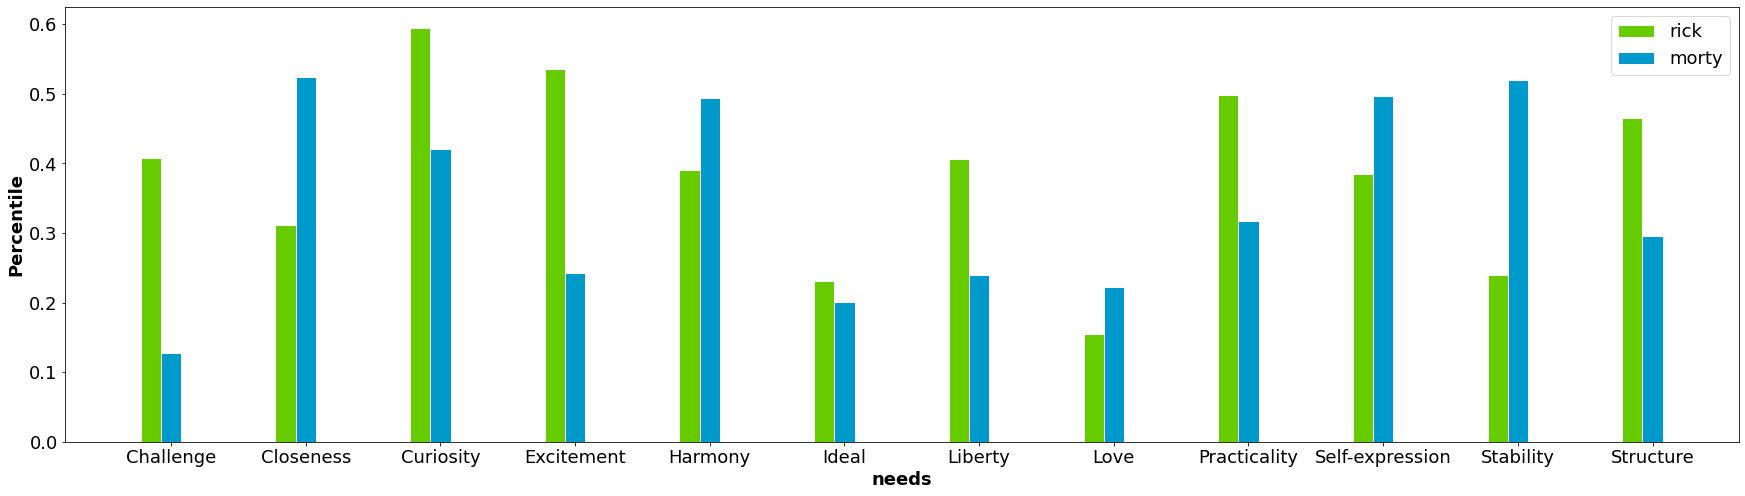

In [636]:
rnm_create_personality_plot('needs')

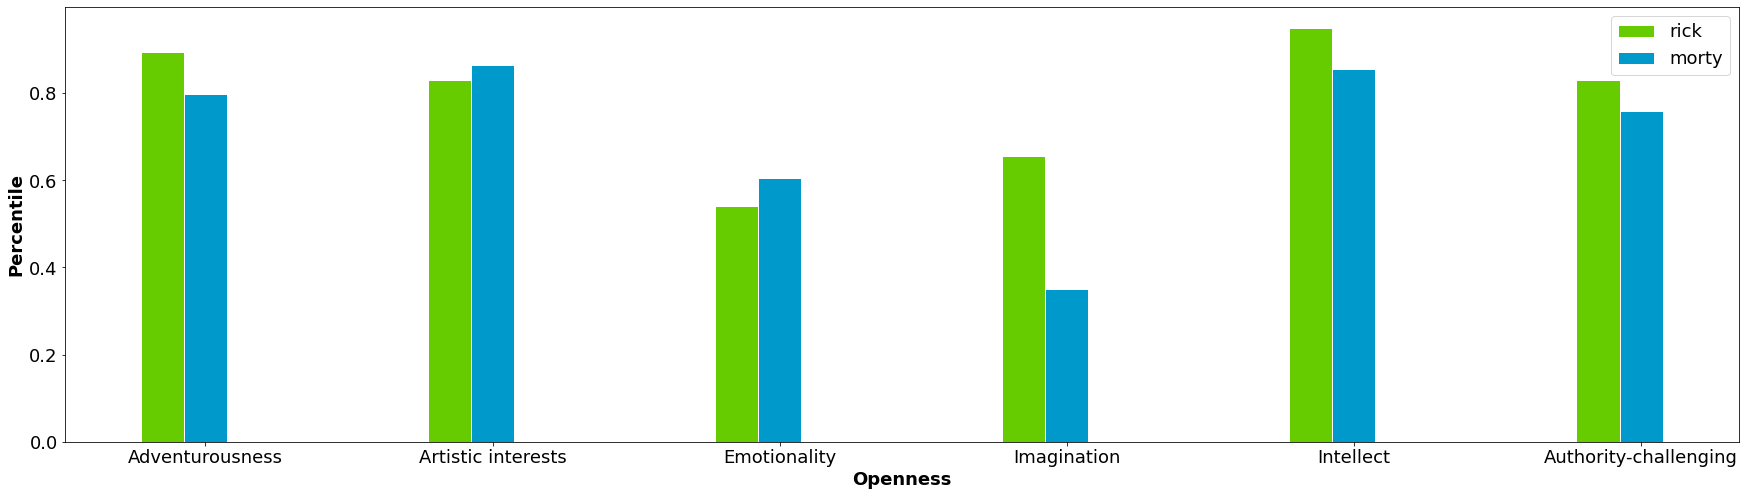

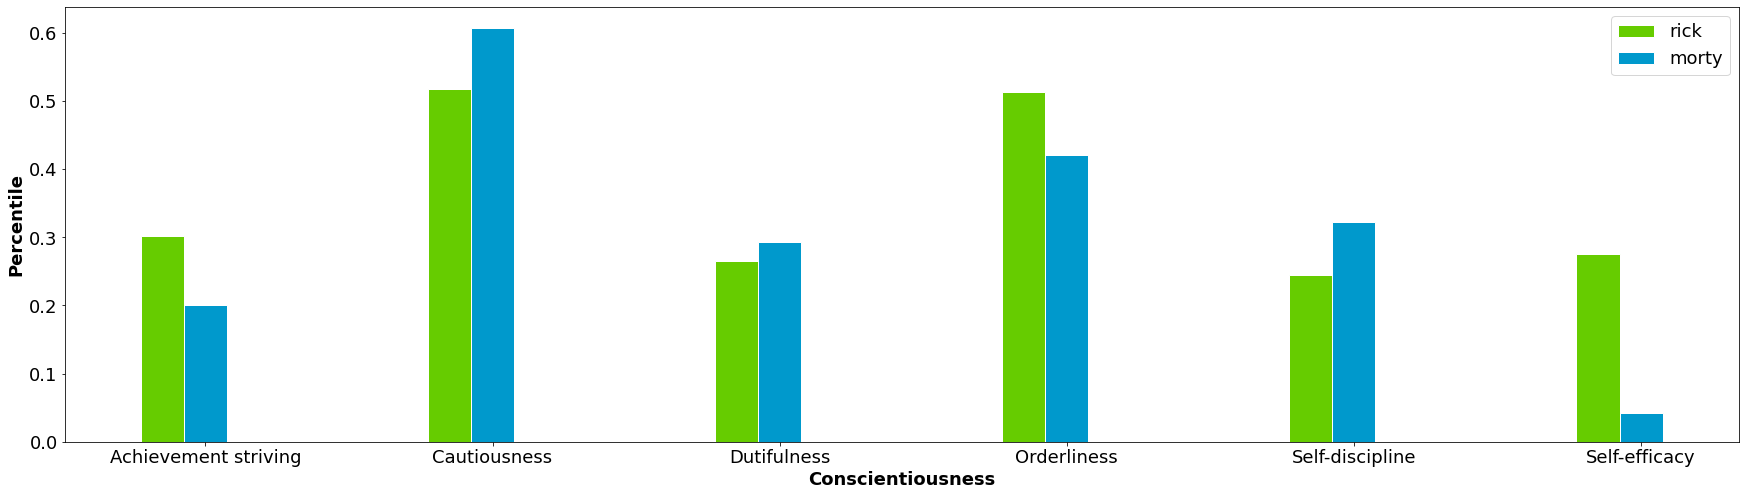

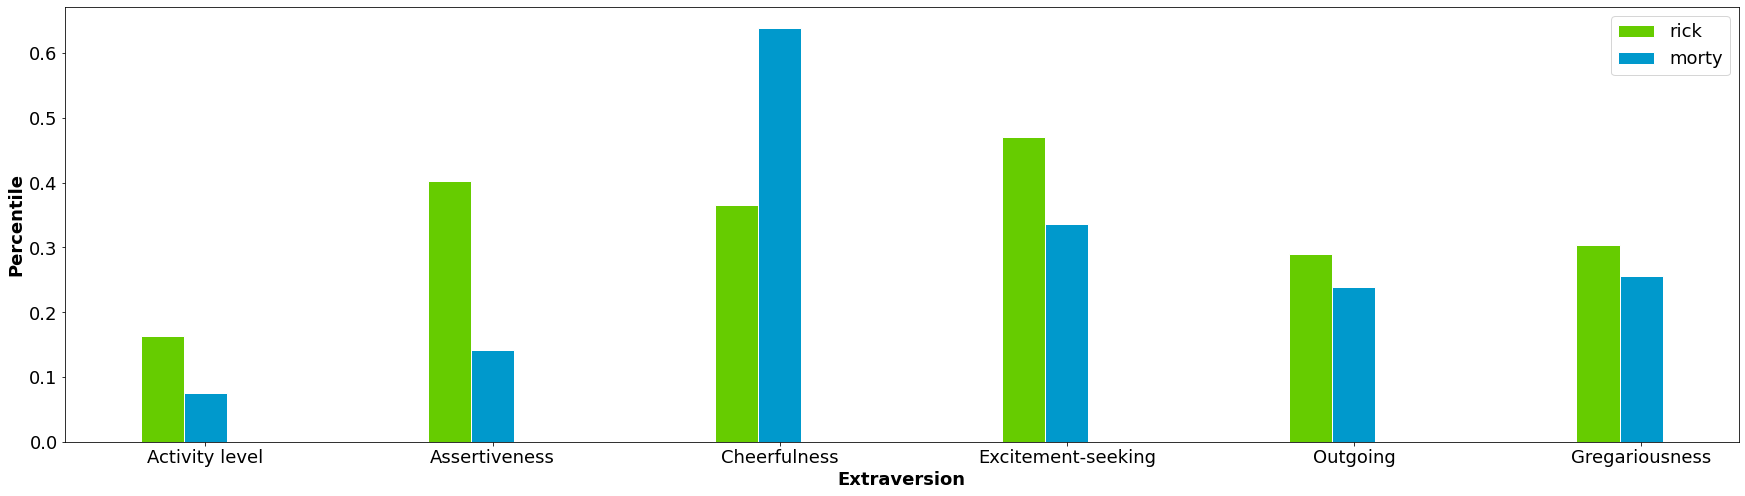

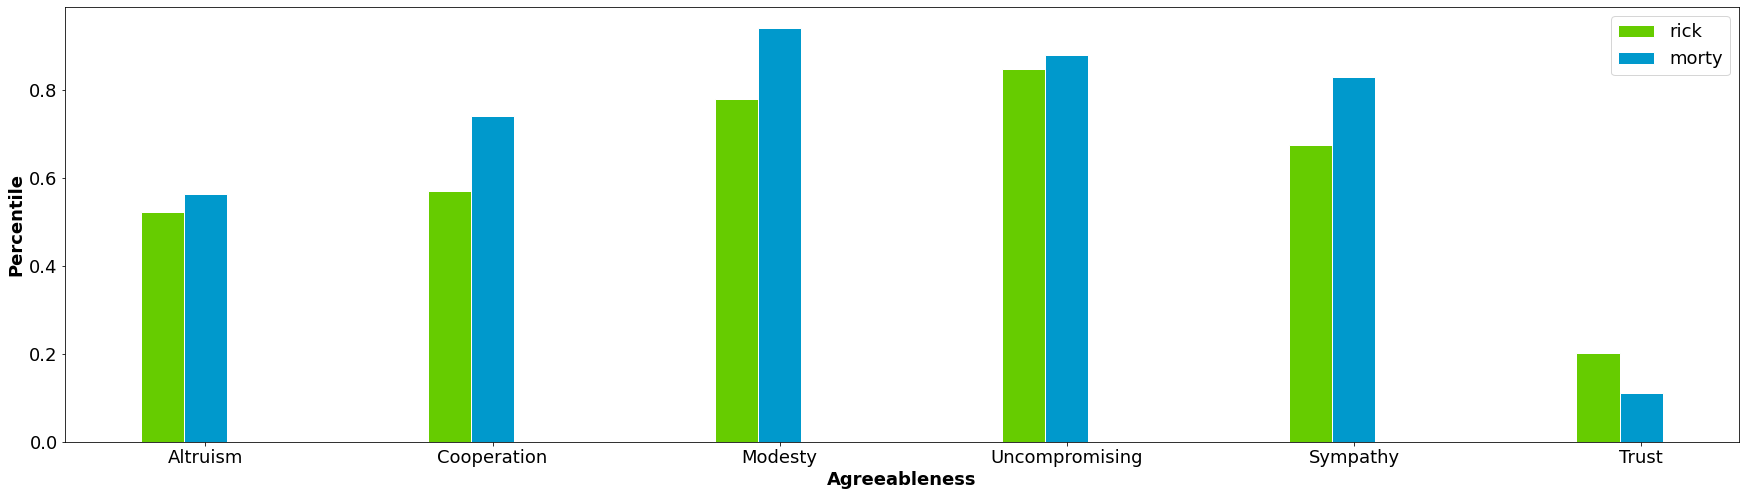

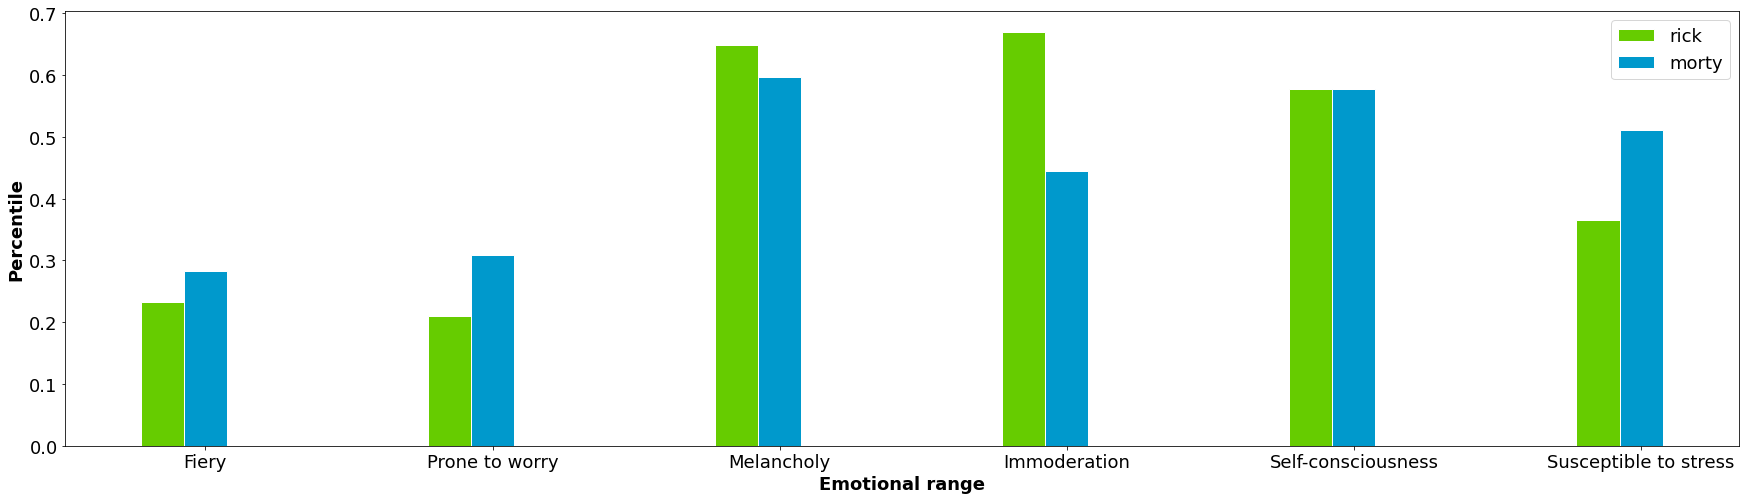

In [153]:
for i, big5 in enumerate(rick_profile['personality']):
    labels = [child['name'] for child in big5['children']]
    rick_p = [child['percentile'] for child in big5['children']]
    morty_p = [child['percentile'] for child in morty_profile['personality'][i]['children']]


    barWidth = 0.15  # the width of the bars

    # Set position of bar on X axis
    r1 = np.arange(len(rick_p))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Make the plot
    plt.bar(r1, rick_p, color='#66cc00', width=barWidth, edgecolor='white', label='rick')
    plt.bar(r2, morty_p, color='#0099cc', width=barWidth, edgecolor='white', label='morty')



    # Add xticks on the middle of the group bars
    plt.xlabel(big5['name'], fontweight = 'bold')
    plt.xticks([r + barWidth for r in range(len(rick_p))], labels)
    plt.rcParams["figure.figsize"] = (30,8)
    matplotlib.rcParams.update({'font.size': 18})
    plt.ylabel('Percentile', fontweight = 'bold')

    # Create legend & Show graphic
    plt.legend()
    plt.show()